In [4]:
import os
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

,de,en
0,An der B 211 befindet sich in Loyermoor der so...,Here the largest town of the district is locat...
1,Ich begrüße die Erklärung des Herrn Kommissar ...,"I should like, in passing, to pay tribute to t..."
2,"Das ist das Gegenteil von dem, was getan werde...",That is the opposite of what should be done an...
3,.,.
4,The Ethnographical museum in Varna is in a hou...,It was designed by the Viennese architect Rupp...


Dataset size: (4508785, 2)
Missing values:
de    0
en    0
dtype: int64


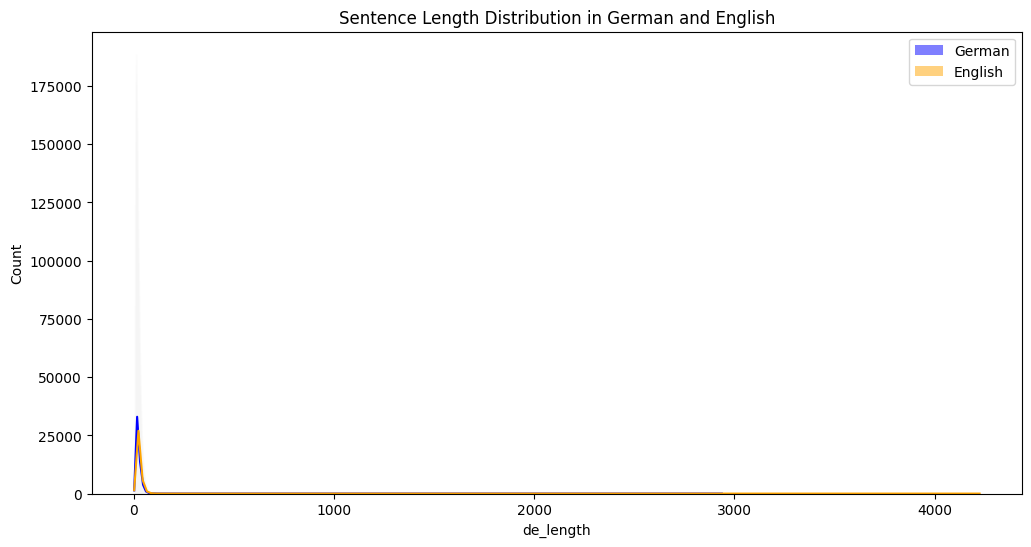

In [ ]:
dataset = pd.read_csv('../data/wmt14_translate_de-en_train.csv', lineterminator='\n')

# Explore the dataset
display(dataset.head())
print(f'Dataset size: {dataset.shape}')
print(f'Missing values:\n{dataset.isnull().sum()}')

dataset.describe()

# Plot length of sentences in German and English
dataset['de_length'] = dataset['de'].apply(lambda x: len(x.split()))
dataset['en_length'] = dataset['en'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(dataset['de_length'], color="blue", label="German", kde=True)
sns.histplot(dataset['en_length'], color="orange", label="English", kde=True)
plt.legend()
plt.title('Sentence Length Distribution in German and English')
plt.show()


In [ ]:
nrows = 18000

In [17]:
data_dir = '../data'
train_raw = pd.read_csv(os.path.join(data_dir, 'wmt14_translate_de-en_train.csv'), lineterminator='\n', nrows=nrows)
test_raw = pd.read_csv(os.path.join(data_dir, 'wmt14_translate_de-en_test.csv'), lineterminator='\n')
val_raw = pd.read_csv(os.path.join(data_dir, 'wmt14_translate_de-en_validation.csv'), lineterminator='\n')

In [10]:
train_raw.shape

(18000, 2)

In [11]:
train_raw.head()

,de,en
0,An der B 211 befindet sich in Loyermoor der so...,Here the largest town of the district is locat...
1,Ich begrüße die Erklärung des Herrn Kommissar ...,"I should like, in passing, to pay tribute to t..."
2,"Das ist das Gegenteil von dem, was getan werde...",That is the opposite of what should be done an...
3,.,.
4,The Ethnographical museum in Varna is in a hou...,It was designed by the Viennese architect Rupp...


In [ ]:
# Function to clean text data (e.g., lowercasing, removing special characters)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# Clean both German and English text
train_raw['de'] = train_raw['de'].apply(clean_text)
train_raw['en'] = train_raw['en'].apply(clean_text)
val_raw['de'] = val_raw['de'].apply(clean_text)
val_raw['en'] = val_raw['en'].apply(clean_text)
test_raw['de'] = test_raw['de'].apply(clean_text)
test_raw['en'] = test_raw['en'].apply(clean_text)

# Initialize tokenizers and add special tokens
special_tokens = ['<start>', '<end>']

# German Tokenizer
de_tokenizer = Tokenizer(filters='', oov_token='<unk>')
de_tokenizer.fit_on_texts(special_tokens)  # Ensure special tokens are included
de_tokenizer.fit_on_texts(train_raw['de'].tolist() + val_raw['de'].tolist() + test_raw['de'].tolist())

# English Tokenizer
en_tokenizer = Tokenizer(filters='', oov_token='<unk>')
en_tokenizer.fit_on_texts(special_tokens)  # Ensure special tokens are included
en_tokenizer.fit_on_texts(train_raw['en'].tolist() + val_raw['en'].tolist() + test_raw['en'].tolist())

# Tokenize and pad the sequences
def tokenize_and_pad(texts, tokenizer, max_len=30):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# Prepare sequences using the fitted tokenizers
max_len = 1024  # Set a suitable max length for padding
train_de_sequences = tokenize_and_pad(train_raw['de'], de_tokenizer, max_len)
train_en_sequences = tokenize_and_pad(train_raw['en'], en_tokenizer, max_len)
val_de_sequences = tokenize_and_pad(val_raw['de'], de_tokenizer, max_len)
val_en_sequences = tokenize_and_pad(val_raw['en'], en_tokenizer, max_len)
test_de_sequences = tokenize_and_pad(test_raw['de'], de_tokenizer, max_len)
test_en_sequences = tokenize_and_pad(test_raw['en'], en_tokenizer, max_len)

# Vocabulary sizes
de_vocab_size = len(de_tokenizer.word_index) + 1  # Add 1 for padding token
en_vocab_size = len(en_tokenizer.word_index) + 1  # Add 1 for padding token

print(f'German vocabulary size: {de_vocab_size}')
print(f'English vocabulary size: {en_vocab_size}')

German vocabulary size: 64048
English vocabulary size: 37986


In [13]:
# Encoder Class
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_state=True)
    
    def call(self, inputs):
        x = self.embedding(inputs)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c


# Decoder Class with Attention Mechanism
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.attention = Attention()
        self.dense = TimeDistributed(Dense(vocab_size, activation='softmax'))

    def call(self, inputs, context_vector, initial_state):
        x = self.embedding(inputs)
        lstm_output, _, _ = self.lstm(x, initial_state=initial_state)
        attention_output = self.attention([lstm_output, context_vector])
        decoder_concat_input = Concatenate()([lstm_output, attention_output])
        output = self.dense(decoder_concat_input)
        return output

In [14]:
def build_model(en_vocab_size, de_vocab_size, embedding_dim, hidden_units, max_len):
    # Encoder
    encoder_input = Input(shape=(max_len,), name='encoder_input')
    encoder_emb = Embedding(en_vocab_size, embedding_dim, input_length=max_len)(encoder_input)
    encoder_lstm = LSTM(hidden_units, return_state=True, dropout=0.5)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_input = Input(shape=(max_len - 1,), name='decoder_input')  # Shifted by 1
    decoder_emb = Embedding(de_vocab_size, embedding_dim, input_length=max_len-1)(decoder_input)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.5)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)
    
    decoder_dense = Dense(de_vocab_size, activation='softmax')
    decoder_output = decoder_dense(decoder_lstm_out)
    
    model = Model([encoder_input, decoder_input], decoder_output)
    
    return model

embedding_dim = 256
lstm_units = 512

model = build_model(en_vocab_size, de_vocab_size, embedding_dim, lstm_units, max_len)

# Print model summary
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1731088275.385836  244810 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20933 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 256)   │  9,724,416 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 29, 256)   │ 16,396,288 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 29, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 29, 64048) │ 32,856,624 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,127,152 (237.00 MB)

 Trainable params: 62,127,152 (237.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


I0000 00:00:1731088279.957012  246543 cuda_dnn.cc:529] Loaded cuDNN version 90300


282/282 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.3774 - loss: 6.4083 - val_accuracy: 0.4629 - val_loss: 4.5937
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4023 - loss: 4.8155 - val_accuracy: 0.4667 - val_loss: 4.5507
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4111 - loss: 4.5855 - val_accuracy: 0.4725 - val_loss: 4.5060
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4205 - loss: 4.3395 - val_accuracy: 0.4741 - val_loss: 4.5043
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4283 - loss: 4.1192 - val_accuracy: 0.4760 - val_loss: 4.5266
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4372 - loss: 3.9016 - val_accuracy: 0.4766 - val_loss: 4.5534
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4426 - loss: 3.7216 - val_accuracy: 0.4778 - val_loss: 4.5857
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4528 - loss: 3.5234 - val

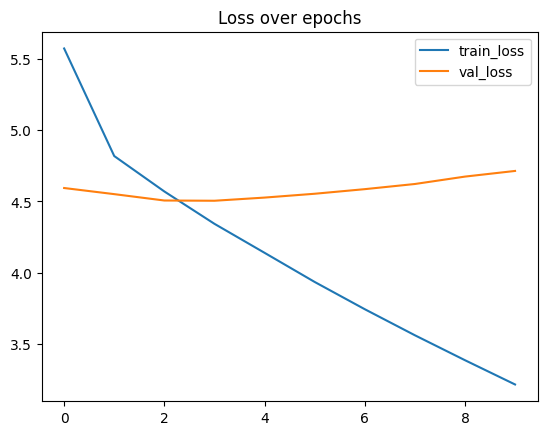

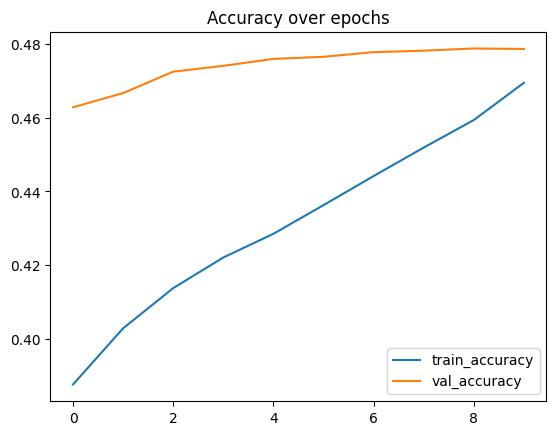

In [15]:
train_en_sequences = pad_sequences(train_en_sequences, maxlen=max_len, padding='post')
train_de_sequences = pad_sequences(train_de_sequences, maxlen=max_len, padding='post')

# Decoder input and output (padded to match sequence length)
decoder_input = train_de_sequences[:, :-1]  # Shifted German sequence
decoder_output = np.expand_dims(train_de_sequences[:, 1:], -1)  # Shifted German sequence

# Train the model (do not redefine the model here)
# Training example: Pass encoder_input and decoder_input with appropriate shapes
history = model.fit(
    [train_en_sequences, train_de_sequences[:, :-1]],
    np.expand_dims(train_de_sequences[:, 1:], -1),
    epochs=10,
    batch_size=64,
    validation_data=(
        [val_en_sequences, val_de_sequences[:, :-1]],
        np.expand_dims(val_de_sequences[:, 1:], -1)
    )
)

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()


In [ ]:
model_path = '../checkpoints/seq2seq_attention_' + f"{nrows}"
model.save(f'{model_path}.weights.keras')

In [13]:
model_path = '../checkpoints/seq2seq_attention_' + f"{nrows}"
restored_model = tf.keras.models.load_model(f'{model_path}.weights.keras')

preds = restored_model.predict([test_en_sequences[:5], test_de_sequences[:5, :-1]])

# Function to convert sequences to text
def sequences_to_text(sequences, tokenizer):
    word_index = tokenizer.word_index
    index_word = {v: k for k, v in word_index.items()}
    return ' '.join(index_word[i] for i in sequences if i != 0)

# Convert the sequences to text
for i in range(5):
    print(f'English: {sequences_to_text(test_en_sequences[i], en_tokenizer)}')
    print(f'German: {sequences_to_text(test_de_sequences[i], de_tokenizer)}')
    print(f'Predicted German: {sequences_to_text(np.argmax(preds[i], axis=1), de_tokenizer)}')
    print()
    

/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
English: the school yard renovation was originally planned back in 20082009 however high unplanned expenses meant that the work had to be pushed back
German: ursprünglich war die schulhofsanierung sogar schon in den jahren 20082009 geplant doch hohe unplanmäßige ausgaben brachten eine verschiebung
Predicted German: ist die stadt der die in der letzten die zusammengefasst dass dass problem zu zu und große für

English: consequently they will be particularly motivated playing against their former coach
German: von daher werden sie gegen ihren excoach sicher ganz besonders motiviert sein
Predicted German: der ist wir die die bericht zu zu

English: theyre not all experienced racers but people looking for excitement and adventure and an achievable path towards worldclass events
German: sie sind nicht alle erfahrene rennfahrer sondern leute die auf der suche nach spannung und abenteuer sind sowie nach einem erreichbaren weg zu weltklasseveranstaltungen

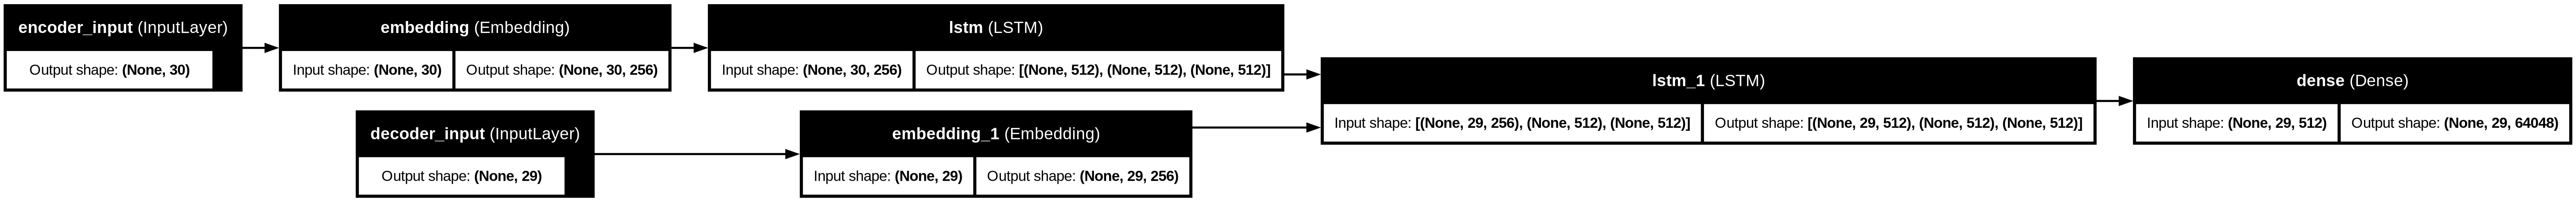

In [16]:
from keras.utils import plot_model
plot_model(restored_model, to_file='../outputs/lstm_model.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True)

In [13]:
# Calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu_score(actual, predicted):
    actual = [[str(sentence).split()] for sentence in actual]
    predicted = [str(sentence).split() for sentence in predicted]
    return corpus_bleu(actual, predicted)

# Convert the sequences to text
predicted_sentences = []
for i in range(len(test_en_sequences)):
    predicted_sequence = np.argmax(restored_model.predict([test_en_sequences[i:i+1], test_de_sequences[i:i+1, :-1]])[0], axis=1)
    predicted_sentences.append(sequences_to_text(predicted_sequence, de_tokenizer))

# Calculate BLEU score  
bleu_score = calculate_bleu_score(test_raw['de'], predicted_sentences)
print(f'BLEU Score: {bleu_score}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━